In [1]:
from langchain_openai import ChatOpenAI
import os 
from dotenv import load_dotenv
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

#Define LLM
model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=OPENAI_API_KEY
)

In [2]:
import pandas as pd
from faker import Faker
import random
from datetime import datetime

fake = Faker()

makers_list = ["Toyota", "Volkswagen", "Hyundai", "Honda", "Maruti Suzuki", "Tata Motors", "Mahindra"]
model_types = ["Sedan", "Hatchback", "SUV"]

def generate_leasing_data(num_records=50):
    data_records = []
    for i in range(num_records):
        make = random.choice(makers_list)
        model = random.choice(model_types)
        
        lease_term = random.choice(["12 months", "24 months", "36 months", "48 months", "60 months"])
        flexi = random.choice(["Yes", "No"])
        tax_plan = random.choice(["Yes", "No"])
        renewal = random.choice(["Monthly", "Quarterly", "Yearly"])
        maintenance = random.choice(["Roadside", "Garage"])
        
        product_name = f"{make} {model} Lease Plan"
        description = (
            f"{lease_term} {model.lower()} lease from {make} "
            f"with {'flexible terms' if flexi=='Yes' else 'standard terms'}, "
            f"{'tax saving benefits' if tax_plan=='Yes' else 'no tax saving plan'}, "
            f"and {maintenance.lower()} support."
        )
        
        record = {
            "Product ID": f"P{1000+i}",  
            "Product Name": product_name,  
            "Short Description": description,
            "Lease Term": lease_term,
            "Flexi Lease": flexi,
            "Tax Saving Plan": tax_plan,
            "Renewal Cycle": renewal,
            "Maintenance Type": maintenance,
            "Inserted Date": fake.date_between_dates(
                date_start=datetime(2022,1,1), 
                date_end=datetime(2025,8,1)
            )
        }
        data_records.append(record)
    return pd.DataFrame(data_records)

# --- Generate & Save ---
leasing_data = generate_leasing_data(100)
leasing_data.to_csv("leasing_data.csv", index=False)


In [3]:
import pandas as pd
from faker import Faker
from random import choice, randint
from datetime import datetime, timedelta
from langchain.docstore.document import Document

fake = Faker()
NUM_RECORDS = 500

# Pools
existing_customer_pool = [fake.unique.random_int(min=1000, max=2000) for _ in range(100)]  # reused
vehicle_ids = [fake.unique.random_int(min=1, max=100) for _ in range(100)]
product_ids = [fake.unique.random_int(min=1, max=50) for _ in range(50)]

used_new_customers = set()
contracts = []
docs = []

for i in range(1, NUM_RECORDS + 1):
    # Decide if existing or new customer
    if randint(1, 100) <= 60:  # 60% chance existing
        customer_id = choice(existing_customer_pool)
        existing_customer = "yes"
    else:
        # Ensure new customer appears only once
        while True:
            customer_id = fake.unique.random_int(min=2001, max=5000)
            if customer_id not in used_new_customers:
                used_new_customers.add(customer_id)
                break
        existing_customer = "no"

    # Discount and preferred flags
    discount_applied = "yes" if existing_customer == "yes" and randint(1, 100) <= 30 else "no"
    preferred_customer = "yes" if existing_customer == "yes" and randint(1, 100) <= 20 else "no"

    # Lease dates
    lease_start = fake.date_between(start_date="-2y", end_date="today")
    lease_term_months = choice([12, 24, 36, 48])
    lease_expiry = lease_start + timedelta(days=lease_term_months*30)

    # Other fields
    vehicle_id = choice(vehicle_ids)
    product_id = choice(product_ids)
    monthly_emi = randint(300, 1000)
    road_assistance = choice(["yes", "no"])
    maintenance = choice(["yes", "no"])

    # Contract dict
    contract = {
        "Contract ID": i,
        "Customer ID": customer_id,
        "Existing Customer": existing_customer,
        "Vehicle ID": vehicle_id,
        "Product ID": product_id,
        "Monthly EMI": monthly_emi,
        "Lease Start Date": lease_start,
        "Lease Expiry Date": lease_expiry,
        "Road Assistance": road_assistance,
        "Maintenance": maintenance,
        "Discount Applied": discount_applied,
        "Preferred Customer": preferred_customer
    }
    contracts.append(contract)

    # Contract summary for vector DB
    summary = (
        f"Contract {i}: Lease of Vehicle {vehicle_id} under Product {product_id} "
        f"for {lease_term_months} months, EMI {monthly_emi} USD, "
        f"Road Assistance: {road_assistance}, Maintenance: {maintenance}, "
        f"Existing Customer: {existing_customer}, Discount Applied: {discount_applied}, "
        f"Preferred Customer: {preferred_customer}"
    )

    docs.append(Document(page_content=summary, metadata={
        "contract_id": i,
        "customer_id": customer_id,
    }))

# Save CSV
df_contracts = pd.DataFrame(contracts)
df_contracts.to_csv("contracts_data.csv", index=False)

In [4]:
import sqlite3
import pandas as pd
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.schema import Document

In [5]:
embeddings = OpenAIEmbeddings(api_key=OPENAI_API_KEY)
contract_vector_db = FAISS.from_documents(docs, embeddings)

# Save FAISS index locally
contract_vector_db.save_local("contracts_faiss")

print("✅ Contract data loaded into Vector DB")

✅ Contract data loaded into Vector DB


In [6]:
csv_file = "vehicle_data.csv"
df = pd.read_csv(csv_file)

# sqlite_file = "vehicles.db"
# conn = sqlite3.connect(sqlite_file)

# # Write DataFrame into SQLite
# df.to_sql("vehicles", conn, if_exists="replace", index=False)

# # Confirm
# cursor = conn.cursor()
# cursor.execute("PRAGMA table_info(vehicles);")
# print("SQLite Schema:", cursor.fetchall())

In [7]:
docs = []
for _, row in df.iterrows():
    text = (
        f"Country: {row['Country']}, Make: {row['Make']}, Model: {row['Model']}, Year: {row['Year']}, "
        f"Mileage: {row['Mileage']}, Fuel: {row['Fuel']}, Gear: {row['Gear Type']}, "
        f"Horsepower: {row['Horsepower']}, Price: {row['Price']} {row['Currency']}, "
        f"Preowned: {row['Preowned']}, Inserted: {row['Inserted date']}"
    )
    docs.append(Document(page_content=text, metadata={"Vehicle ID": row["Vehicle ID"]}))

# Create embeddings + FAISS index
embeddings = OpenAIEmbeddings(api_key=OPENAI_API_KEY)
vector_db = FAISS.from_documents(docs, embeddings)

# Save FAISS index locally
vector_db.save_local("vehicle_faiss")

print("✅ Data loaded into SQLite and Vector DB")

✅ Data loaded into SQLite and Vector DB


In [8]:
csv_file = "leasing_data.csv"
df = pd.read_csv(csv_file)

# sqlite_file = "leasing.db"
# conn = sqlite3.connect(sqlite_file)

# # Write DataFrame into SQLite
# df.to_sql("leasing", conn, if_exists="replace", index=False)

# # Confirm
# cursor = conn.cursor()
# cursor.execute("PRAGMA table_info(leasing);")
# print("SQLite Schema:", cursor.fetchall())

In [9]:
docs = []
for _, row in df.iterrows():
    text = (
        f"Product Name: {row['Product Name']}, "
        f"Description: {row['Short Description']}, "
        f"Lease Term: {row['Lease Term']}, "
        f"Flexi Lease: {row['Flexi Lease']}, "
        f"Tax Saving Plan: {row['Tax Saving Plan']}, "
        f"Renewal Cycle: {row['Renewal Cycle']}, "
        f"Maintenance Type: {row['Maintenance Type']}, "
        f"Inserted Date: {row['Inserted Date']}"
    )
    docs.append(Document(page_content=text, metadata={"Product ID": row["Product ID"]}))

# Create embeddings + FAISS index
embeddings = OpenAIEmbeddings(api_key=OPENAI_API_KEY)
product_vector_db = FAISS.from_documents(docs, embeddings)

# Save FAISS index locally
product_vector_db.save_local("product_faiss")

print("✅ Product leasing data loaded into Vector DB")

✅ Product leasing data loaded into Vector DB


In [10]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing import List,Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph, END
from langchain_community.utilities import SQLDatabase
from tabulate import tabulate
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field

In [11]:

# prompt_template = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             "You talk like a Car leasing Agent. Answer all questions to the best of your ability in {language}.",
#         ),
#         MessagesPlaceholder(variable_name="messages"),
#     ]
# )

In [12]:
# class State(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], add_messages]
#     language: str


# workflow = StateGraph(state_schema=State)


# def call_model(state: State):
#     prompt = prompt_template.invoke(state)
#     response = model.invoke(prompt)
#     return {"messages": [response]}


# workflow.add_edge(START, "model")
# workflow.add_node("model", call_model)

# memory = MemorySaver()
# app = workflow.compile(checkpointer=memory)

In [13]:
# config = {"configurable": {"thread_id": "abc456"}}
# query = "Hi! I'm Bob."
# language = "English"

# input_messages = [HumanMessage(query)]
# # output = app.invoke(
# #     {"messages": input_messages, "language": language},
# #     config,
# # )
# # output["messages"][-1].pretty_print()
# for chunk, metadata in app.stream(
#     {"messages": input_messages, "language": language},
#     config,
#     stream_mode="messages",
# ):
#     if isinstance(chunk, AIMessage):  # Filter to just model responses
#         print(chunk.content, end="")


In [14]:
#state

class AgentState(TypedDict):
    query: str 
    route : List[str] 
    product_vector_result : str
    vehicle_vector_result : str
    contract_vector_result : str
    rewritten_query: str 
    contract_filters: str
    vehicle_filters: str
    product_filters: str
    final_answer : str 
    trace : List[List[str]]
    customer_id: str


# db connections

# vehicle_sql_db = SQLDatabase.from_uri("sqlite:///vehicles.db")
# product_vector_db = SQLDatabase.from_uri("sqlite:///leasing.db")

vehicle_vector_db = FAISS.load_local("vehicle_faiss", embeddings, allow_dangerous_deserialization= True)
product_vector_db = FAISS.load_local("product_faiss", embeddings, allow_dangerous_deserialization= True)
contract_vector_db = FAISS.load_local("contracts_faiss", embeddings, allow_dangerous_deserialization= True)

# vehicle_retriever = vehicle_vector_db.as_retriever(search_kwargs={"k": 3})
# product_retriever = product_vector_db.as_retriever(search_kwargs={"k": 3})
# contract_retriever = contract_vector_db.as_retriever(search_kwargs={"k": 3})

In [15]:
# Step 1: Define output schema
class RouterOutput(BaseModel):
    rewritten_query: str = Field(..., description="Rewritten, clarified query")
    contract_filters: str = Field(description="The contract related filter")
    vehicle_filters: str= Field(description="The vehicle related filter")
    product_filters: str = Field(description="The product related filter")
    route: List[str] = Field(description="The chosen route: vehicle, product, contract, general")

# Step 2: Parser


In [16]:
router_template = """
You are a **Contract Query Router** inside a vehicle-leasing system. 
Your job is to take any user query in natural language and turn it into:
- A rewritten, clarified query
- Structured filters for searching Contract DB, Vehicle DB, and Product DB
- A routing plan (which DBs to query)

---
### Knowledge of Fields

**Contract fields**:
- customer_id
- existing_customer (Yes/No)
- vehicle_id
- product_id
- monthly_emi
- lease_start_date
- lease_expiry_date
- road_assistance (Yes/No)
- maintenance (Yes/No)
- discount_applied
- preferred_customer (Yes/No)

**Vehicle fields**:
- country
- make
- model
- year
- mileage
- fuel
- gear_type
- horsepower
- price
- currency
- preowned (Yes/No)
- inserted_date

**Product fields**:
- product_name
- short_description
- lease_term
- flexi_lease (Yes/No)
- tax_saving_plan (Yes/No)
- renewal_cycle
- maintenance_type
- inserted_date

---
### Query Understanding Rules

1. **Rewrite the query**
   - Normalize vague words into explicit meaning (e.g., “ongoing contracts” → “contracts where lease_expiry_date >= today”).
   - Expand short questions into complete sentences if needed.
   - Keep the rewritten query user-friendly but explicit.

2. **Extract filters**
   - Identify which fields are implied by the user query.
   - If a filter is implied but not exact, still output it. Examples:
     - “current” / “active” / “ongoing” → `lease_expiry_date >= today`
     - “expired contracts” → `lease_expiry_date < today`
     - “my SUV contracts” → Vehicle filter `Model : SUV`
     - “maintenance included” → Contract filter `Maintenance: Yes`
     - “roadside help” → Contract filter `road_assistance: Yes`
     - “flexi lease” → Product filter `flexi_lease: Yes`

3. **Routing decision**
   - If user mentions “contract”, or asks about my agreements, route includes `"contract"`.
   - If query contains vehicle details (make, model, fuel, mileage, horsepower), include `"vehicle"`.
   - If query contains product/plan terms (lease term, flexi lease, tax saving, EMI, renewal, maintenance type), include `"product"`.
   - Can include multiple, e.g. “Show me contracts for my SUV with flexi lease” → route = ["contract", "vehicle", "product"]

---
### Output Format

Return valid JSON only:

{{
  "rewritten_query": "<rewritten natural language query>",
  "contract_filters": <contract_field>: <value>, ... ,
  "vehicle_filters": <vehicle_field>: <value>, ... ,
  "product_filters": <product_field>: <value>, ... ,
  "route": ["contract", "vehicle", "product"]
}}

---
### Examples

User: "Show me my ongoing SUV contracts with maintenance"
Output:
{{
  "rewritten_query": "Show contracts where lease_expiry_date is after today, vehicle model is SUV, and maintenance is included.",
  "contract_filters": "maintenance: Yes,lease_expiry_date": >= today",
  "vehicle_filters": "model: SUV" 
  "product_filters": "",
  "route": ["contract", "vehicle"]
}}

User: "Which contracts are still active?"
Output:
{{
  "rewritten_query": "Show contracts where lease_expiry_date is after today.",
  "contract_filters": "lease_expiry_date: >= today",
  "vehicle_filters": "",
  "product_filters": "",
  "route": ["contract"]
}}

User: "Do I have a flexi lease plan for my Toyota?"
Output:
{{
  "rewritten_query": "Show contracts with flexi lease enabled for vehicle make Toyota.",
  "contract_filters": "",
  "vehicle_filters": "make: Toyota",
  "product_filters": "flexi_lease: Yes",
  "route": ["contract", "vehicle", "product"]
}}

### User Query 
Query: {input}

{format_instructions}
"""

In [17]:
# router node

def route_query(state: AgentState) -> AgentState:
#     vehicle_fields = ["Country", "Make", "Model", "Year", "Mileage", "Fuel", "Gear Type", "Horsepower", "Price", "Currency", "Preowned", "Inserted date"]
#     product_fields = ["Product Name", "Short Description", "Lease Term", "Flexi Lease", "Tax Saving Plan", "Renewal Cycle", "Maintenance Type", "Inserted Date"]
#     contract_fields = ["Customer ID", "Existing Customer", "Vehicle ID", "Product ID", "Monthly EMI", "Lease Start Date", "Lease Expiry Date", "Road Assistance", "Maintenance", "Discount Applied", "Preferred Customer"]

#     destinations = [
#     {"name": "vehicle", "description": f"Queries about Vehicle fields: {', '.join(vehicle_fields)}"},
#     {"name": "product", "description": f"Queries about Leasing products/plans: {', '.join(product_fields)}"},
#     {"name": "contract", "description": f"Queries about Contracts: {', '.join(contract_fields)}"},
#     {"name": "general", "description": "General questions not related to leasing or vehicles"}
# ]

    # router_template = """You are a routing agent. 
    # Available destinations:
    # {destinations}

    # Query: {input}

    # Return a JSON with the key "destination" with value vehicle, product, contract, or general.

    # {format_instructions}
    # """
    parser = PydanticOutputParser(pydantic_object=RouterOutput)
    router_prompt = PromptTemplate(
        template=router_template,
        input_variables=["input"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    router_chain = LLMChain(
        llm=model,  # your ChatOpenAI instance
        prompt=router_prompt,
        output_parser=parser
    )
    
    query = state["query"]
    response = router_chain.invoke({
    "input": query,
    #"destinations": "\n".join([f"- {d['name']}: {d['description']}" for d in destinations])
                              
})
    print(response["text"])
    decision = response["text"].route
    state["route"] = decision
    state['rewritten_query'] = response['text'].rewritten_query
    state['product_filters'] = response['text'].product_filters
    state['vehicle_filters'] = response['text'].vehicle_filters
    state['contract_filters'] = response['text'].contract_filters
    state.setdefault("trace", []).append(["ROUTER", f"Query='{query}' → Route='{decision}'"])
    return state


In [18]:
def inject_filters(query: str, filters: str, entity: str) -> str:
        """Turn natural-language filters into query modifiers."""
        if not filters:
            return query
        return f"{query}. Additionally filter {entity} records by: {filters}"

In [19]:
# vehicle node
def vehicle_node(state):
    vehicle_query = inject_filters(state["rewritten_query"],state["vehicle_filters"],"vehicles")
    docs = vehicle_vector_db.similarity_search(
            vehicle_query,
            k=5
        )
    context = "\n".join([d.page_content for d in docs])
    state["vehicle_vector_result"] = context
    state["trace"].append(["VEHICLE VECTOR", f"Retrieved {len(context)} docs"])

    prompt = ChatPromptTemplate.from_template(
        "Answer based on VEHICLE data:\nContext: {context}\n\nUser Question: {query}\nAnswer:"
    )
    chain = LLMChain(llm=model, prompt=prompt)
    result = chain.invoke({"context": context, "query": vehicle_query})
    response = result['text']

    state["trace"].append(["VEHICLE ANSWER", response[:80] + ("..." if len(response) > 80 else "")])
    state["final_answer"] = response
    return state

def product_node(state):
    product_query = inject_filters(state["rewritten_query"],state["product_filters"],"product")
    docs = product_vector_db.similarity_search(
            product_query,
            k=5
        )
    context = "\n".join([d.page_content for d in docs])
    state["product_vector_result"] = context
    state["trace"].append(["PRODUCT VECTOR", f"Retrieved {len(context)} docs"])

    prompt = ChatPromptTemplate.from_template(
        "Answer based on Leasing Product data:\nContext: {context}\n\nUser Question: {query}\nAnswer:"
    )
    chain = LLMChain(llm=model, prompt=prompt)
    result = chain.invoke({"context": context, "query": product_query})
    response = result['text']

    state["trace"].append(["PRODUCT ANSWER", response[:80] + ("..." if len(response) > 80 else "")])
    state["final_answer"] = response
    return state

def general_node(state):
    query = state["rewritten_query"]
    prompt = ChatPromptTemplate.from_template(
        "This is a general question unrelated to vehicle or product or contracts.\nUser: {query}\nAnswer directly:"
    )
    chain = LLMChain(llm=model, prompt=prompt)
    result = chain.invoke({"query": query})
    response = result['text']

    state["trace"].append(["GENERAL ANSWER", response[:80] + ("..." if len(response) > 80 else "")])
    state["final_answer"] = response
    return state


In [30]:
def contract_node(state):
    """
    Contract node: always runs contract search.
    If vehicle/product filters exist, extract IDs from matched contracts 
    and use them in vehicle/product DB searches.
    """
    customer_id = state["customer_id"]

    results = {
        "contract": [],
        "vehicle": [],
        "product": []
    }

    # --- Always enforce customer_id in contracts ---
    contract_filters = {"customer_id": customer_id}
    print("customer id",contract_filters)

    # --- Contract search ---
    if "contract" in state['route']:
        contract_query = inject_filters(state['rewritten_query'], state['contract_filters'], "contract")
        results["contract"] = contract_vector_db.similarity_search(contract_query, k=10,filter=contract_filters)
        print(results["contract"])
        state["trace"].append(["CONTRACT VECTOR", f"Retrieved {len(results['contract'])} docs"])


    # --- Extract vehicle IDs from contracts ---
    vehicle_ids = [c.metadata.get("vehicle_id") for c in results["contract"] if c.metadata.get("vehicle_id")]
    print(vehicle_ids,"VEHICLE")

    if "vehicle" in state['route'] and (state['vehicle_filters'] or vehicle_ids):
        # Build vehicle query with IDs
        vehicle_query = inject_filters(state['rewritten_query'], state['vehicle_filters'], "vehicle")
        vehicle_metadata_filter = {}
        
        if vehicle_ids:  # ✅ only add join if we actually have vehicle_ids
            vehicle_metadata_filter["Vehicle ID"] = {"$in": vehicle_ids}

        results["vehicle"] = vehicle_vector_db.similarity_search(
            vehicle_query,
            filter=vehicle_metadata_filter if vehicle_metadata_filter else None,  # ✅ remove filter if no IDs
            k=5
        )
        state["trace"].append(["CONTRACT VEHICLE VECTOR", f"Retrieved {len(results['vehicle'])} docs"])

    # --- Extract product IDs from contracts ---
    product_ids = [c.metadata.get("product_id") for c in results["contract"] if c.metadata.get("product_id")]
    print(product_ids,"PRODUCT")

    if "product" in state['route'] and (state['product_filters'] or product_ids):
        product_query = inject_filters(state['rewritten_query'], state['product_filters'], "product")
        product_metadata_filter = {}
        
        if product_ids:  # ✅ only add join if we actually have vehicle_ids
            product_metadata_filter["Product ID"] = {"$in": product_ids}

        results["product"] = product_vector_db.similarity_search(
            product_query,
            filter=product_metadata_filter if product_metadata_filter else None,  # ✅ remove filter if no IDs
            k=5
        )
        state["trace"].append(["CONTRACT PRODUCT VECTOR", f"Retrieved {len(results['product'])} docs"])
    prompt = ChatPromptTemplate.from_template(
        "Answer based on Contract data:\nContext: {context}\n\nUser Question: {query}\nAnswer:"
    )
    chain = LLMChain(llm=model, prompt=prompt)
    result = chain.invoke({"context": results, "query": state['rewritten_query']})
    response = result['text']
    state["trace"].append(["CONTRACT ANSWER", response[:80] + ("..." if len(response) > 80 else "")])
    state["final_answer"]=response

    return state


In [31]:
# pipeline
# add nodes
graph = StateGraph(AgentState)
graph.add_node("router", route_query)
graph.add_node("vehicle", vehicle_node)
graph.add_node("product", product_node)
graph.add_node("contract", contract_node)
graph.add_node("general", general_node)


graph.set_entry_point("router")
graph.add_conditional_edges(
    "router",
    lambda state: (
        "contract" if "contract" in state["route"] 
        else "vehicle" if "vehicle" in state["route"] 
        else "product" if "product" in state["route"] 
        else "general"
    ),
    {
        "contract": "contract",
        "vehicle": "vehicle",
        "product": "product",
        "general": "general"
    }
)

graph.add_edge("vehicle", END)
graph.add_edge("product", END)
graph.add_edge("contract", END)
graph.add_edge("general", END)

agent = graph.compile()


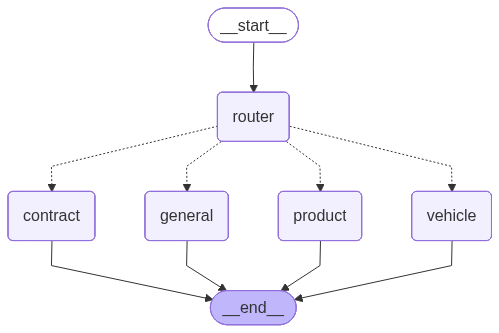

In [32]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [33]:
query = "Suggest my contract"
result = agent.invoke({"query": query,"trace": [],"customer_id": "2567"})
print(result["final_answer"])

rewritten_query='Please show me my contract details.' contract_filters='' vehicle_filters='' product_filters='' route=['contract']
customer id {'customer_id': '2567'}
[]
[] VEHICLE
[] PRODUCT
It appears that there are no contract details available at this time. Please check back later or provide more information if you have specific details or questions regarding your contract.


In [34]:
# ---- Print Trace Table ----
print("\n--- Execution Trace ---")
print(tabulate(result["trace"], headers=["Node", "Output"], tablefmt="grid"))


--- Execution Trace ---
+-----------------+-------------------------------------------------------------------------------------+
| Node            | Output                                                                              |
+=================+=====================================================================================+
| ROUTER          | Query='Suggest my contract' → Route='['contract']'                                  |
+-----------------+-------------------------------------------------------------------------------------+
| CONTRACT VECTOR | Retrieved 0 docs                                                                    |
+-----------------+-------------------------------------------------------------------------------------+
| CONTRACT ANSWER | It appears that there are no contract details available at this time. Please che... |
+-----------------+-------------------------------------------------------------------------------------+
